Importing the required libraries and setting up paths of directories

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
base_dir='drive/My Drive/Tumor'
train_dir=os.path.join(base_dir,'training_set')
validation_dir=os.path.join(base_dir,'validation_set')
test_dir=os.path.join(base_dir,'test_set')

In [ ]:
train_yes_dir = os.path.join(train_dir, 'Yes') 
train_no_dir = os.path.join(train_dir, 'No') 
validation_yes_dir = os.path.join(validation_dir, 'Yes')
validation_no_dir = os.path.join(validation_dir, 'No')
test_yes_dir = os.path.join(test_dir, 'Yes')
test_no_dir = os.path.join(test_dir, 'No')

train_yes_fnames = os.listdir(train_yes_dir)
train_no_fnames = os.listdir(train_no_dir)

Number of samples in train set

In [ ]:
print(len(train_yes_fnames)+len(train_no_fnames))

140


Number of samples in dev set

In [ ]:
print(len(os.listdir(validation_no_dir))+len(os.listdir(validation_yes_dir)))

40


Number of samples in test set

In [ ]:
print(len(os.listdir(test_no_dir))+len(os.listdir(test_yes_dir)))

20


Data pre-processing and augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=16
img_size=(128,128)
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 15,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = img_size)    

validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = img_size)
test_generator=validation_datagen.flow_from_directory(test_dir,
                                                      class_mode  = 'binary', 
                                                      target_size = img_size,
                                                      shuffle=False)

Found 140 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Feteching the VGG16 network architecture pre-trained on the Imagenet dataset and freezing its layers

In [ ]:
from tensorflow.python.keras.applications.vgg16 import VGG16
img_shape=img_size+(3,)
basemodel=VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape
)
basemodel.trainable=False
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Adding two FC layers with batch normalization and dropout on top of VGG16

In [ ]:
from tensorflow.keras.optimizers import Adam

headmodel=layers.Flatten()(basemodel.output)
headmodel=layers.Dense(1024)(headmodel)
headmodel=layers.BatchNormalization()(headmodel)
headmodel=layers.Activation('relu')(headmodel)
headmodel=layers.Dropout(0.2)(headmodel)
headmodel=layers.Dense(512)(headmodel)
headmodel=layers.BatchNormalization()(headmodel)
headmodel=layers.Activation('relu')(headmodel)
headmodel=layers.Dropout(0.3)(headmodel)
headmodel=layers.Dense(1,activation='sigmoid')(headmodel)

model=Model(inputs=basemodel.input,outputs=headmodel)

model.compile(optimizer=Adam(lr=0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)    

Training on our dataset

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1,
    baseline=0.5, restore_best_weights=True
)
epochs=20
history=model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=epochs,
    validation_steps=validation_generator.n//batch_size,
    verbose=2,
    #callbacks=[callback]
)

Epoch 1/20
8/8 - 2s - loss: 0.8075 - accuracy: 0.5484 - val_loss: 0.7133 - val_accuracy: 0.5625
Epoch 2/20
8/8 - 2s - loss: 0.5168 - accuracy: 0.7177 - val_loss: 1.0003 - val_accuracy: 0.4688
Epoch 3/20
8/8 - 2s - loss: 0.4595 - accuracy: 0.7581 - val_loss: 1.0061 - val_accuracy: 0.5000
Epoch 4/20
8/8 - 2s - loss: 0.4392 - accuracy: 0.7177 - val_loss: 0.9556 - val_accuracy: 0.5000
Epoch 5/20
8/8 - 2s - loss: 0.3676 - accuracy: 0.7984 - val_loss: 0.9149 - val_accuracy: 0.5000
Epoch 6/20
8/8 - 2s - loss: 0.2218 - accuracy: 0.9194 - val_loss: 0.8255 - val_accuracy: 0.5000
Epoch 7/20
8/8 - 2s - loss: 0.3112 - accuracy: 0.8871 - val_loss: 0.7295 - val_accuracy: 0.5625
Epoch 8/20
8/8 - 2s - loss: 0.3680 - accuracy: 0.8065 - val_loss: 0.8753 - val_accuracy: 0.5000
Epoch 9/20
8/8 - 2s - loss: 0.3318 - accuracy: 0.8387 - val_loss: 0.6697 - val_accuracy: 0.6250
Epoch 10/20
8/8 - 2s - loss: 0.3158 - accuracy: 0.8629 - val_loss: 0.7847 - val_accuracy: 0.5938
Epoch 11/20
8/8 - 2s - loss: 0.3079 - a

Graphs - No. of epochs vs. accuracy/loss

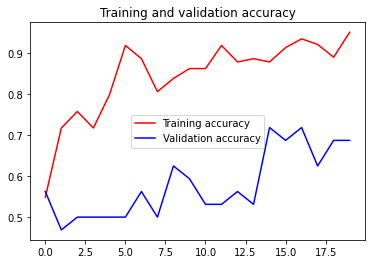

<Figure size 432x288 with 0 Axes>

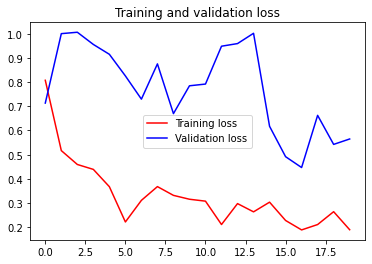

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Classifying test images

1/1 [==============================] - 0s 78ms/step
              precision    recall  f1-score   support

          No       0.91      1.00      0.95        10
         Yes       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



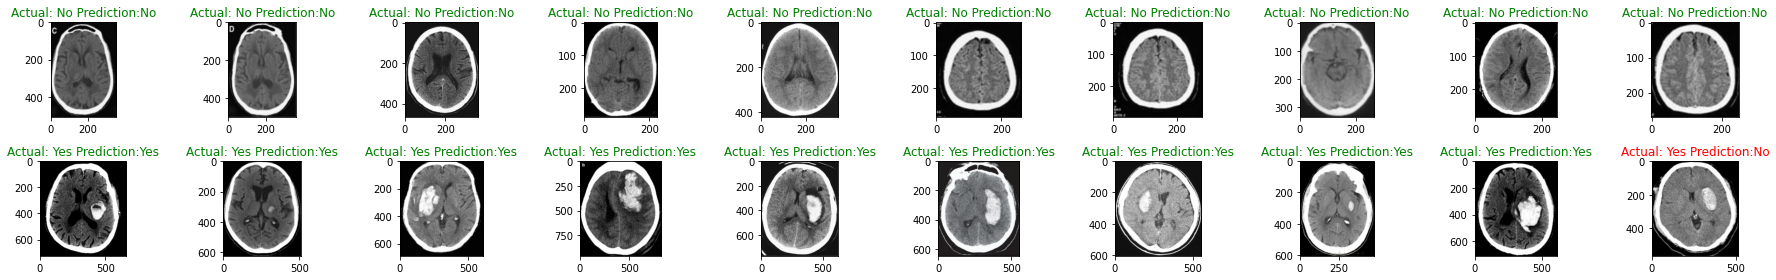

In [ ]:
test_generator.reset()
prediction=model.predict(test_generator,verbose=1)
prediction[prediction>0.5]=1
prediction[prediction<=0.5]=0
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, prediction,
	target_names=test_generator.class_indices.keys()))
import PIL
fig,axs=plt.subplots(2,10,figsize=(25,4))
count=0
for i in os.listdir(test_dir):
  test_class=os.listdir(os.path.join(test_dir,i))
  for j in range(10):
    img=os.path.join(test_dir,i,test_class[j])
    pred=("No" if prediction[j+count*10]==0 else "Yes")
    title="Actual: "+i+" Prediction:"+pred
    axs[count][j].set_title(title,
                                 color=("green" if pred==i else "red"))
    axs[count][j].imshow(PIL.Image.open(img))
  count+=1
fig.tight_layout()

In [ ]:
#model.save(filepath='drive/My Drive/Tumor/classificationmodel(_).h5',save_format='h5')